In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['test-data', 'training-data', 'mortgage-approvals-data']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import xgboost
import lightgbm as lgb

train = pd.read_csv("../input/training-data/train_values_1.csv")
y_labels = pd.read_csv("../input/mortgage-approvals-data/train_labels.csv")
train['accepted'] = y_labels['accepted']

#### Handle Missing Values

In [3]:
train.fillna(train.median(), inplace=True)
train = train.drop(columns=['Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27','Unnamed: 28'])
train.describe()

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,accepted
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,249999.500000,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,181.606972,23.726924,144.542062,2.036228,4.786586,1.462374,100.121312,5396.982356,31.225669,69158.876302,92.200385,1423.172866,1880.147458,0.500540,3720.121344,0.500228
std,144337.711634,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,138.464169,15.982768,100.243612,0.511351,1.024927,0.677685,147.474440,2667.723303,25.798784,14478.232811,13.990187,721.027517,893.717989,0.222693,1838.313175,0.500000
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.534000,17858.000000,3.981000,4.000000,1.000000,0.000000,0.000000,0.000000
25%,124999.750000,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,25.000000,6.000000,57.000000,2.000000,5.000000,1.000000,49.000000,3805.000000,11.191000,60071.000000,89.145000,963.000000,1323.000000,0.370000,2442.000000,0.000000
50%,249999.500000,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,192.000000,26.000000,131.000000,2.000000,5.000000,1.000000,74.000000,4975.000000,22.901000,67526.000000,100.000000,1327.000000,1753.000000,0.490000,3731.000000,1.000000
75%,374999.250000,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,314.000000,37.000000,246.000000,2.000000,5.000000,2.000000,112.000000,6379.000000,44.486000,74714.250000,100.000000,1754.000000,2275.000000,0.670000,5436.000000,1.000000
max,499999.000000,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,408.000000,52.000000,324.000000,4.000000,7.000000,4.000000,10139.000000,37097.000000,100.000000,125248.000000,100.000000,8771.000000,13623.000000,1.000000,6508.000000,1.000000


In [4]:
train.shape

(500000, 24)

#### Feature Engineering

In [5]:
# add loan_income_ratio
train['loan_income_ratio'] = train['loan_amount'] / train['applicant_income']

# add location_code = state_code * county_code
train['location_code'] = train['state_code'] * train['county_code']

# add applicant_race_ethnicity = applicant_ethnicity * applicant_race
train['applicant_race_eth'] = train['applicant_race'] * train['applicant_ethnicity']

# add family_income = high, medium, low
train['family_income'] = train['ffiecmedian_family_income'].apply(lambda value: ('low' if value <= 30000.00 else 'medium') if value <= 90000.00 else 'high')
train['family_income'] = pd.Categorical(train['family_income'], categories=['low', 'medium', 'high'])

train.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,accepted,loan_income_ratio,location_code,applicant_race_eth,family_income
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,0.84,4536,False,1,2.916667,9102,10,medium
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,0.17,2458,False,0,3.122807,15548,5,medium
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,0.49,5710,False,1,2.432836,3060,10,medium


In [6]:
# add applicant income to FFIEC family median income ratio
train['applicant_income_to_family_median_income_ratio'] = (train['applicant_income'] / train['ffiecmedian_family_income'])
train.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,accepted,loan_income_ratio,location_code,applicant_race_eth,family_income,applicant_income_to_family_median_income_ratio
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,0.84,4536,False,1,2.916667,9102,10,medium,0.000396
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,0.17,2458,False,0,3.122807,15548,5,medium,0.001040
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,0.49,5710,False,1,2.432836,3060,10,medium,0.000989


#### Encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
train['co_applicant'] = le.fit_transform(train['co_applicant'])
train['family_income'] = le.fit_transform(train['family_income'])
train.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,accepted,loan_income_ratio,location_code,applicant_race_eth,family_income,applicant_income_to_family_median_income_ratio
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,0.84,4536,0,1,2.916667,9102,10,2,0.000396
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,0.17,2458,0,0,3.122807,15548,5,2,0.001040
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,0.49,5710,0,1,2.432836,3060,10,2,0.000989
3,3,1,1,1,1,155,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,0.69,5888,1,1,1.476190,8460,10,2,0.001339
4,4,1,1,1,1,305,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,0.54,289,0,1,4.295775,740,6,2,0.001126


#### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

# target
y = train.pop('accepted')

features = train.drop(columns=['row_id', 'number_of_1_to_4_family_units', 
                                'population', 'applicant_ethnicity', 'state_code', 'county_code',
                               'ffiecmedian_family_income', 'minority_population_pct', 'applicant_race'
                               ])

# features
X = features.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [10]:
X_train.shape, X_test.shape

((400000, 19), (100000, 19))

#### Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

# fit the scaler based upon the training set
scaler = StandardScaler().fit(X_train)

# scale the train features array 
X_train = scaler.transform(X_train)

# scale the test features array (based on the training fit)
X_test = scaler.transform(X_test)

In [12]:
print(X_train[0])

[-0.53006789 -0.20639017 -1.12519645  2.73471192  0.16107647  0.43341641
  1.01368462 -0.68216568  1.2777048  -1.32017066 -0.87834999 -0.13675763
  1.37043465  1.2245599  -0.18104255  0.06533304 -1.45017223 -3.16584101
  0.6000364 ]


#### LightGBM

In [13]:
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.781869	valid_0's binary_logloss: 0.66966	valid_0's l1: 0.487653
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784004	valid_0's binary_logloss: 0.650507	valid_0's l1: 0.476597
[3]	valid_0's auc: 0.785426	valid_0's binary_logloss: 0.634686	valid_0's l1: 0.466661
[4]	valid_0's auc: 0.786362	valid_0's binary_logloss: 0.621438	valid_0's l1: 0.457673
[5]	valid_0's auc: 0.787991	valid_0's binary_logloss: 0.610195	valid_0's l1: 0.449551
[6]	valid_0's auc: 0.788495	valid_0's binary_logloss: 0.600759	valid_0's l1: 0.442193
[7]	valid_0's auc: 0.789068	valid_0's binary_logloss: 0.592753	valid_0's l1: 0.435563
[8]	valid_0's auc: 0.789843	valid_0's binary_logloss: 0.585771	valid_0's l1: 0.429471
[9]	valid_0's auc: 0.790298	valid_0's binary_logloss: 0.579904	valid_0's l1: 0.424013
[10]	valid_0's auc: 0.790946	valid_0's binary_logloss: 0.574752	valid_0's l1: 0.419018
[11]	valid_0's auc: 0.791193	valid_0's binary_logloss: 0.570506	valid_0's l1: 0

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=38,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        importance_type='split', learning_rate=0.125, max_depth=6,
                        metric='l1', min_child_samples=20, min_child_weight=1,
                        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=48,
                        objective='binary', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
                        silent=True, subsample=0.8, subsample_for_bin=200000,
                        subsample_freq=0, num_boost_rounds=500, max_bin=4000, 
                        num_iterations=6000)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)



/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.780663	valid_0's binary_logloss: 0.66435	valid_0's l1: 0.484676
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785412	valid_0's binary_logloss: 0.641772	valid_0's l1: 0.471247
[3]	valid_0's auc: 0.787319	valid_0's binary_logloss: 0.623864	valid_0's l1: 0.459479
[4]	valid_0's auc: 0.788555	valid_0's binary_logloss: 0.609484	valid_0's l1: 0.44915
[5]	valid_0's auc: 0.789246	valid_0's binary_logloss: 0.59785	valid_0's l1: 0.44004
[6]	valid_0's auc: 0.789924	valid_0's binary_logloss: 0.588471	valid_0's l1: 0.432106
[7]	valid_0's auc: 0.790454	valid_0's binary_logloss: 0.580671	valid_0's l1: 0.425004
[8]	valid_0's auc: 0.791289	valid_0's binary_logloss: 0.574088	valid_0's l1: 0.418683
[9]	valid_0's auc: 0.791962	valid_0's binary_logloss: 0.568628	valid_0's l1: 0.413066
[10]	valid_0's auc: 0.7923	valid_0's binary_logloss: 0.564173	valid_0's l1: 0.408139
[11]	valid_0's auc: 0.792925	valid_0's binary_logloss: 0.560427	valid_0's l1: 0.4039

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_bin=4000,
        max_depth=6, metric='l1', min_child_samples=20, min_child_weight=1,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1,
        num_boost_rounds=500, num_iterations=6000, num_leaves=48,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

In [15]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.728
The roc_auc_score of prediction is: 0.7279675066307096
The null acccuracy is: 0.50031


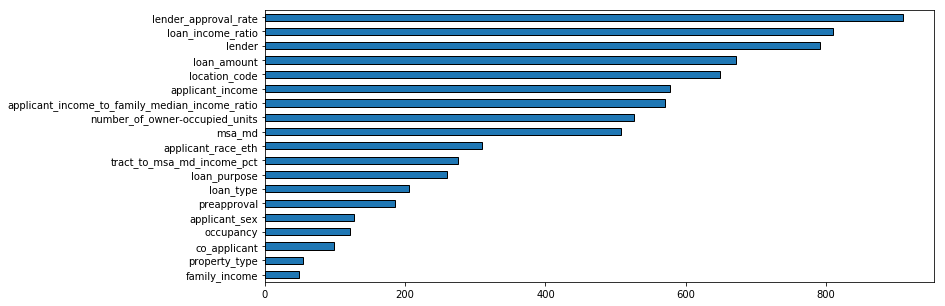

In [16]:
feature_importances = pd.Series(gbm.feature_importances_, index=features.columns)
feature_importances.sort_values(ascending=True).plot(kind="barh", edgecolor="black", color="#1F77B4", figsize=(12,5));

#### Prepare Test Dataset

In [17]:
test = pd.read_csv("../input/test-data/test_values.csv")

In [18]:
# fill missing values
test.fillna(test.median(), inplace=True)
test.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant
0,0,2,1,3,1,115,3,101,16,276,2,5,1,74.0,6329.0,59.536,69889.0,85.78,1874.0,2410.0,0.79,3791,True
1,1,1,1,1,1,252,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,0.37,2839,True
2,2,1,1,1,1,270,1,-1,-1,-1,2,1,2,119.0,4975.0,22.955,67514.0,100.00,1326.0,1753.0,0.20,4701,False


In [19]:
# add feature engineering

# add loan_income_ratio
test['loan_income_ratio'] = test['loan_amount'] / test['applicant_income']

# add location_code = state_code * county_code
test['location_code'] = test['state_code'] * test['county_code']

# add applicant_race_ethnicity = applicant_ethnicity * applicant_race
test['applicant_race_eth'] = test['applicant_race'] * test['applicant_ethnicity']

# add family_income = high, medium, low
test['family_income'] = test['ffiecmedian_family_income'].apply(lambda value: ('low' if value <= 30000.00 else 'medium') if value <= 90000.00 else 'high')
test['family_income'] = pd.Categorical(test['family_income'], categories=['low', 'medium', 'high'])

test.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,loan_income_ratio,location_code,applicant_race_eth,family_income
0,0,2,1,3,1,115,3,101,16,276,2,5,1,74.0,6329.0,59.536,69889.0,85.78,1874.0,2410.0,0.79,3791,True,1.554054,4416,10,medium
1,1,1,1,1,1,252,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,0.37,2839,True,2.355140,1360,10,medium
2,2,1,1,1,1,270,1,-1,-1,-1,2,1,2,119.0,4975.0,22.955,67514.0,100.00,1326.0,1753.0,0.20,4701,False,2.268908,1,2,medium


In [20]:
# add applicant income to FFIEC family median income ratio
test['applicant_income_to_family_median_income_ratio'] = (test['applicant_income'] / test['ffiecmedian_family_income'])
test.head(3)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,loan_income_ratio,location_code,applicant_race_eth,family_income,applicant_income_to_family_median_income_ratio
0,0,2,1,3,1,115,3,101,16,276,2,5,1,74.0,6329.0,59.536,69889.0,85.78,1874.0,2410.0,0.79,3791,True,1.554054,4416,10,medium,0.001059
1,1,1,1,1,1,252,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,0.37,2839,True,2.355140,1360,10,medium,0.001638
2,2,1,1,1,1,270,1,-1,-1,-1,2,1,2,119.0,4975.0,22.955,67514.0,100.00,1326.0,1753.0,0.20,4701,False,2.268908,1,2,medium,0.001763


In [21]:
# encode test features
test['co_applicant'] = le.fit_transform(test['co_applicant'])
test['family_income'] = le.fit_transform(test['family_income'])
test.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender_approval_rate,lender,co_applicant,loan_income_ratio,location_code,applicant_race_eth,family_income,applicant_income_to_family_median_income_ratio
0,0,2,1,3,1,115,3,101,16,276,2,5,1,74.0,6329.0,59.536,69889.0,85.78,1874.0,2410.0,0.79,3791,1,1.554054,4416,10,2,0.001059
1,1,1,1,1,1,252,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,0.37,2839,1,2.355140,1360,10,2,0.001638
2,2,1,1,1,1,270,1,-1,-1,-1,2,1,2,119.0,4975.0,22.955,67514.0,100.00,1326.0,1753.0,0.20,4701,0,2.268908,1,2,2,0.001763
3,3,2,1,1,1,179,2,376,20,11,2,2,2,44.0,4795.0,29.676,57766.0,100.00,1426.0,1765.0,0.82,2153,1,4.068182,220,4,2,0.000762
4,4,2,1,1,1,36,2,254,48,156,3,6,3,32.0,5246.0,5.110,63332.0,100.00,1452.0,2092.0,0.49,5710,0,1.125000,7488,18,2,0.000505


In [22]:
# trim the test set features
test_features = test.drop(columns=['row_id', 'number_of_1_to_4_family_units', 
                                'population', 'applicant_ethnicity', 'state_code', 'county_code',
                               'ffiecmedian_family_income', 'minority_population_pct', 'applicant_race'
                               ])

In [23]:
test_features.head(2)

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,applicant_sex,applicant_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,lender_approval_rate,lender,co_applicant,loan_income_ratio,location_code,applicant_race_eth,family_income,applicant_income_to_family_median_income_ratio
0,2,1,3,1,115,3,101,1,74.0,85.78,1874.0,0.79,3791,1,1.554054,4416,10,2,0.001059
1,1,1,1,1,252,2,87,1,107.0,100.00,947.0,0.37,2839,1,2.355140,1360,10,2,0.001638


In [24]:
# scale the test features array (based on the training fit)
test_features = scaler.transform(test_features)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [25]:
test_features[0]

array([ 0.91774023, -0.20639017,  0.98356665, -0.33611765, -0.20344582,
        0.43341641, -0.58210083, -0.68216568, -0.17740711, -0.45712136,
        0.62796273,  1.29962826,  0.03862557,  1.2245599 , -0.13132109,
        0.26306916,  0.02647443,  0.32089283, -0.18627115])

#### Prediction

In [26]:
# predicting on the "test" dataset, where values are unknown
predict = gbm.predict(test_features)

print(predict)

[1 1 0 ... 0 1 1]


In [27]:
output = pd.DataFrame()
output['row_id'] = y_labels['row_id']
output['accepted'] = predict

In [28]:
output.to_csv("submission_lightgbm.csv", index=False)